### Прогнозирование уровня средней заработной платы в России

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда

- Стабилизация дисперсии (при необходимости)

- Выбор порядка дифференцирования

- Выбор начальных приближений для p,q,P,Q

- Обучение и сравнение моделей-кандидатов, выбор победителя

- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

- Прогнозирование с помощью финальной модели.

In [62]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [63]:
# Проведем визуальный анализ ряда:

In [64]:
data_wages = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data_wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [65]:
data_wages.shape

(284, 1)

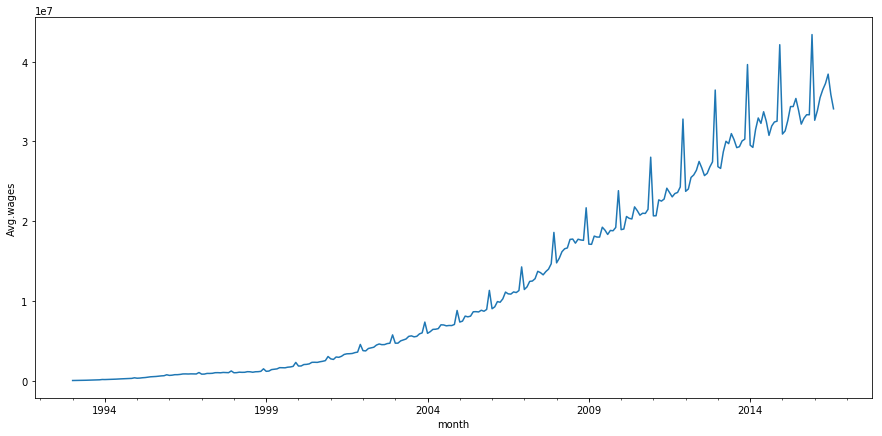

In [66]:
data_wages.columns = ['wage']
data_wages.wage = data_wages.wage * 1000
plt.figure(figsize(15,7))
data_wages.wage.plot()
plt.ylabel('Avg.wages')
pylab.show()

In [67]:
# Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


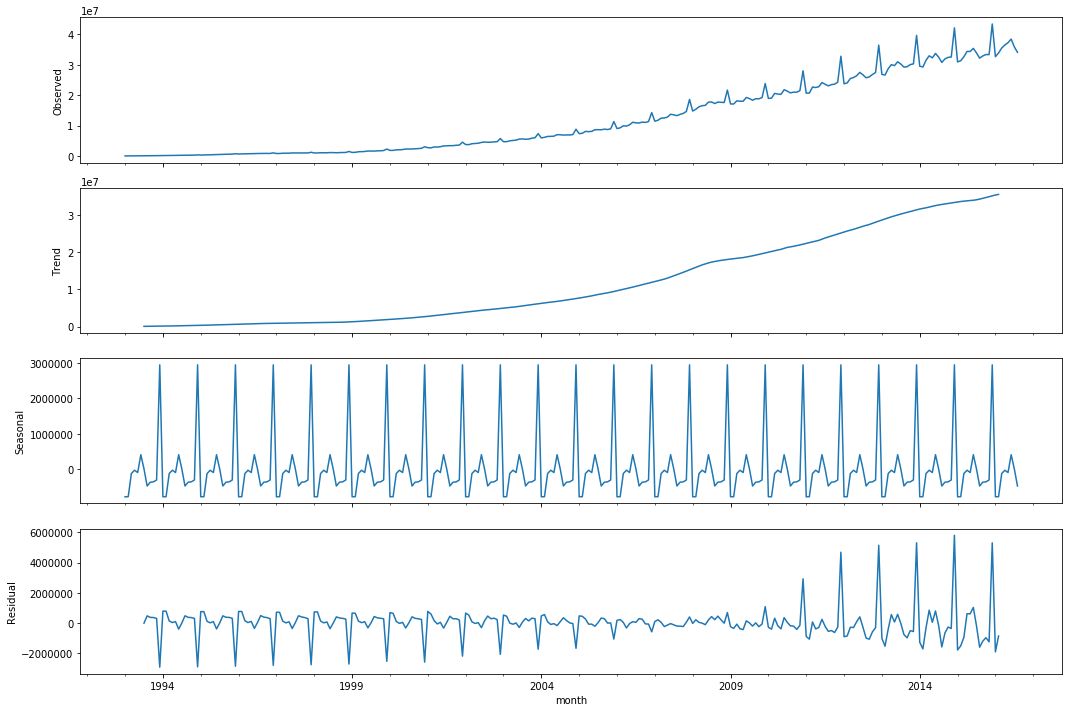

In [68]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_wages.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_wages.wage)[1])

In [12]:
# Из графика и на основании кр. Дики-Фуллера видим, что остатки для ряда смещены и нестационарны. 
# Необходима стабилизация дисперсии, чтобы сделать остатки несмещенными. Для этого сделаем преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


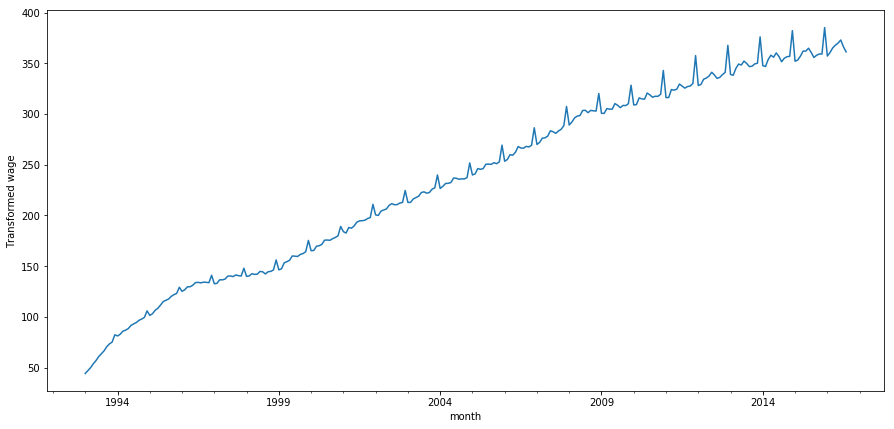

In [69]:
data_wages['wage_box'], lmbda = stats.boxcox(data_wages.wage)
plt.figure(figsize(15,7))
data_wages.wage_box.plot()
plt.ylabel(u'Transformed wage')
print ("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_wages.wage_box)[1])

In [70]:
# На основании критерия Дики-Фуллера видим, что остатки для преобразованного ряда по-прежнему нестационарны. 
# Сделаем сезонное дифференцирование:

In [71]:
data_wages['wage_box_diff12'] = data_wages.wage_box - data_wages.wage_box.shift(12)
data_wages[:20]

,wage,wage_box,wage_box_diff12
month,,,
1993-01-01,15300.0,44.188262,NaN
1993-02-01,19100.0,47.073552,NaN
1993-03-01,23600.0,49.986636,NaN
1993-04-01,30600.0,53.792467,NaN
1993-05-01,37500.0,56.958737,NaN
1993-06-01,47400.0,60.823202,NaN
1993-07-01,56000.0,63.722209,NaN
1993-08-01,65400.0,66.536956,NaN
1993-09-01,80900.0,70.586737,NaN


Критерий Дики-Фуллера: p=0.014697


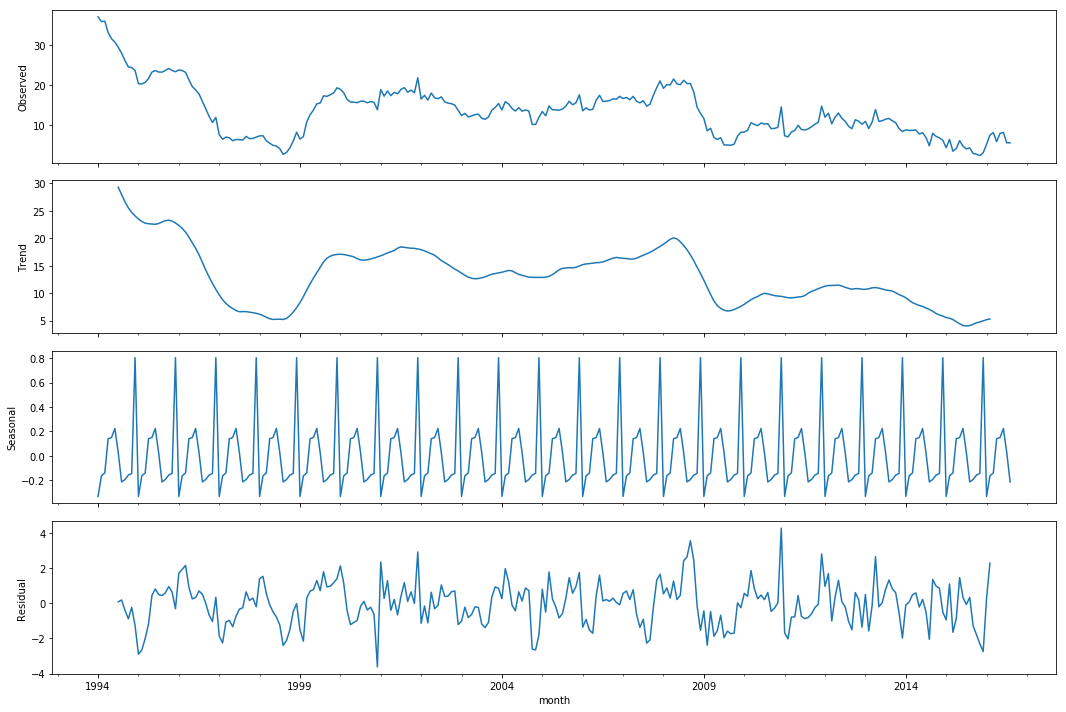

In [72]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_wages.wage_box_diff12[12:]).plot()
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_wages.wage_box_diff12[12:])[1])

In [73]:
# Критерий Дики-Фуллера отвергает гипотезу о нестационарности, но визуально в данных виден тренд. 
# Попробуем добавить ещё обычное дифференцирование: 

Критерий Дики-Фуллера: p=0.000000


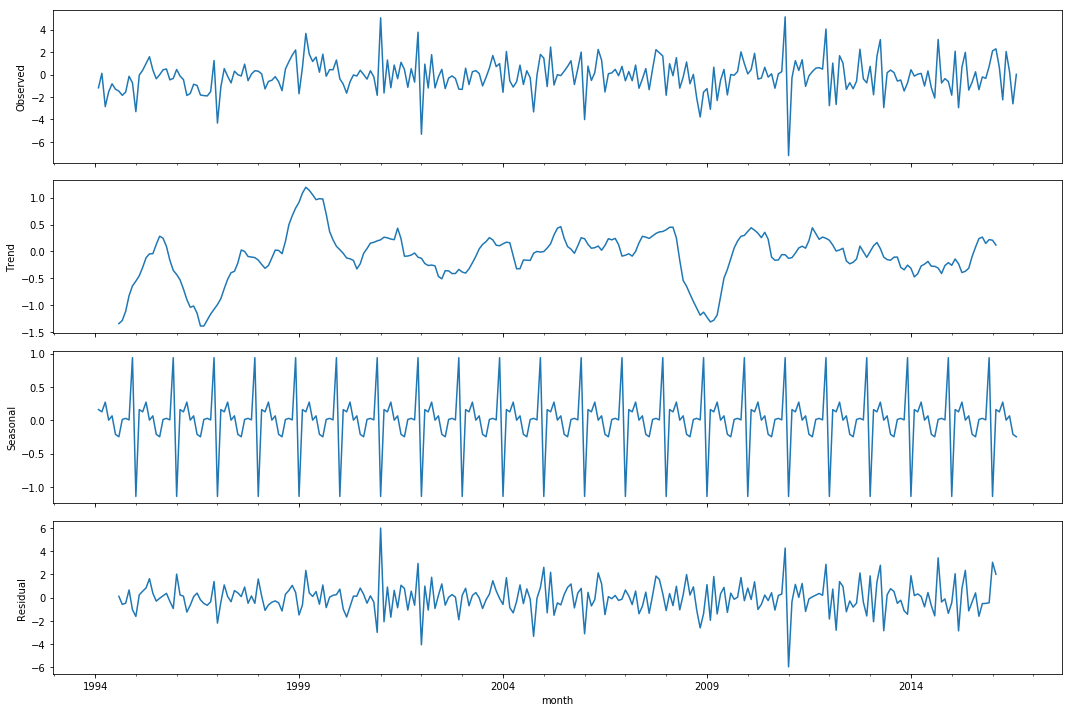

In [74]:
data_wages['wage_box_diff121'] = data_wages.wage_box_diff12 - data_wages.wage_box_diff12.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_wages.wage_box_diff121[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_wages.wage_box_diff121[13:])[1])

In [75]:
# Гипотеза о нестационарности остатков отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

In [76]:
# Выбор начальных приближений для p,q,P,Q
# Посмотрим на ACF и PACF полученного ряда:

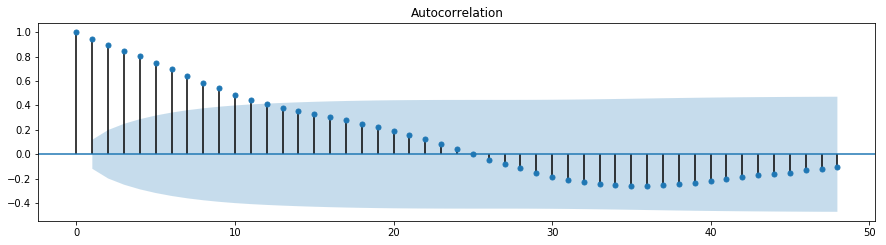

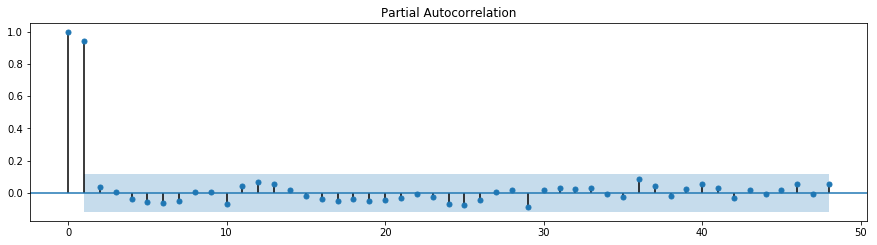

In [77]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_wages.wage_box_diff12[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_wages.wage_box_diff12[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [78]:
# Начальные приближения: p=1,q=11,P=0,Q=0

In [88]:
ps = range(0, 3)
d=0
qs = range(0, 12)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [89]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [90]:
# Обучение и сравнение моделей-кандидатов:

In [91]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_wages.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 3, 0, 0)
wrong parameters: (0, 3, 0, 1)
wrong parameters: (0, 3, 1, 0)
wrong parameters: (0, 3, 1, 1)
wrong parameters: (0, 4, 0, 0)
wrong parameters: (0, 4, 0, 1)
wrong parameters: (0, 4, 1, 0)
wrong parameters: (0, 4, 1, 1)
wrong parameters: (0, 5, 0, 0)
wrong parameters: (0, 5, 0, 1)
wrong parameters: (0, 5, 1, 0)
wrong parameters: (0, 5, 1, 1)
wrong parameters: (0, 6, 0, 0)
wrong parameters: (0, 6, 0, 1)
wrong parameters: (0, 6, 1, 0)
wrong parameters: (0, 6, 1, 1)
wrong parameters: (0, 7, 0, 0)
wrong parameters: (0, 7, 0, 1)
wrong parameters: (0, 7, 1, 0)
wrong parameters: (0, 7, 1, 1)
wrong parameters: (0, 8, 0, 0)
wrong parameters: (0, 8, 0, 1)
wrong parameters: (0, 8, 1, 0)
wrong parameters: (0, 8, 1, 1)
wrong parameters: (0, 9, 0, 0)
wrong parameters: (0, 9, 0, 1)
wrong parameters: (0, 9, 1, 0)
wrong parameters: (0, 9, 1, 1)
wrong pa

In [92]:
# Выбираем лучшую модель

In [93]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
60   (2, 5, 1, 0)  980.323923
37   (1, 9, 1, 1)  980.651813
36   (1, 9, 1, 0)  981.080456
35   (1, 9, 0, 0)  981.141935
39  (1, 10, 1, 0)  981.685632


In [94]:
# Лучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(2, 0, 5)x(1, 1, 0, 12)   Log Likelihood                -481.162
Date:                            Thu, 26 Apr 2018   AIC                            980.324
Time:                                    10:44:08   BIC                           1013.165
Sample:                                01-01-1993   HQIC                           993.490
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6293      0.137     11.927      0.000       1.362       1.897
ar.L2         -0.6315      0.136   

In [95]:
# Проведем анализ остатков выбранной модели - best_model:

Критерий Стьюдента: p=0.530282
Критерий Дики-Фуллера: p=0.000000


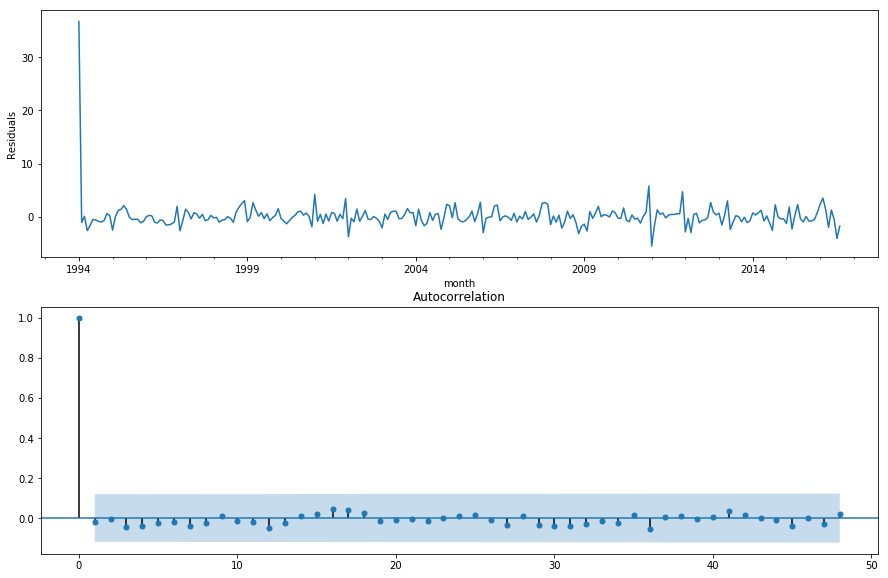

In [96]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1]) # проверка несмещенности
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1]) # проверка стационарности

In [101]:
# Как видно из графиков и на основании критериев Стьюдента и Дики-Фуллера, остатки несмещены и неавтокоррелированы

In [102]:
# Посмотрим, насколько построенная модель хорошо описывает исходные данные

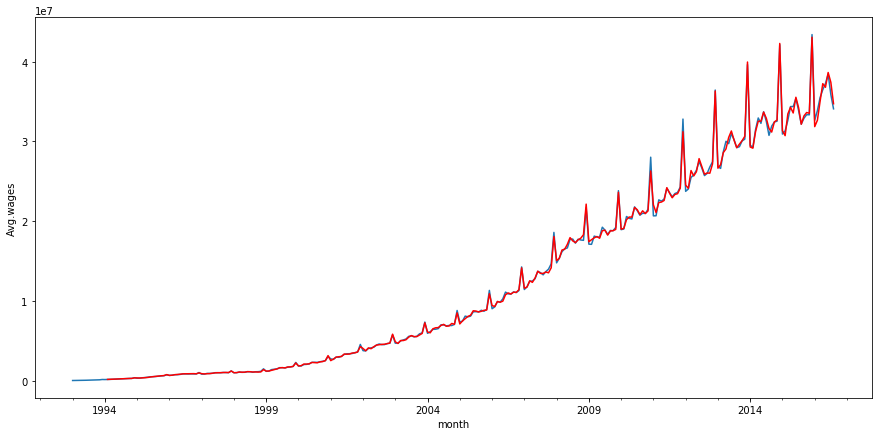

In [103]:
data_wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data_wages.wage.plot()
data_wages.model[13:].plot(color='r')
plt.ylabel('Avg.wages')
pylab.show()

In [104]:
# Видим, что модель адекватно описывает данные

In [105]:
# Построим прогноз на каждый месяц на два года вперёд:

In [106]:
data_wages.tail()

,wage,wage_box,wage_box_diff12,wage_box_diff121,model
month,,,,,
2016-04-01,36497000.0,367.830360,5.807537,-2.255980,3.724989e+07
2016-05-01,37270000.0,369.886066,7.854840,2.047303,3.679832e+07
2016-06-01,38447000.0,372.956651,8.113139,0.258299,3.865105e+07
2016-07-01,35888000.0,366.188082,5.505322,-2.607817,3.742304e+07
2016-08-01,34095000.0,361.230584,5.523488,0.018166,3.473284e+07


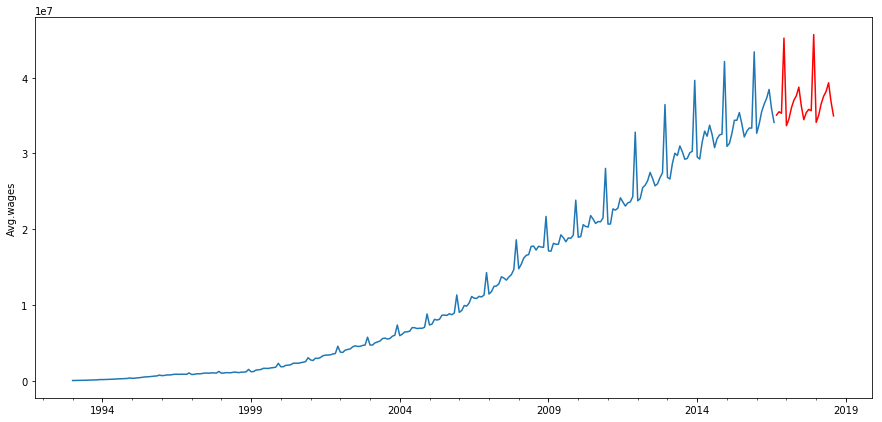

In [107]:
wage2 = data_wages[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.wage.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Avg.wages')
pylab.show()